# [1주차] 심화과제 - MNIST 예측 모델에 deep learning techniques 적용하기

구현 목표 : MNIST 데이터로 손글씨 이미지가 어떤 숫자를 의미하는지 분류하는 모델을 구현한다.

필요한 라이브러리를 import 한다.
GPU를 사용하기 위한 설정을 한다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# mac에 GPU를 사용하기 위한 설정
device = torch.device("mps")

trainset과 testset 준비한다.
PyTorch를 사용하기 위해 다차원 배열인 Tensor 형태로 변환한다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


trainset이 잘 만들어졌는지 확인하기 위해 전체 transet data의 개수와 첫 번째 data를 출력한다.

50000
torch.Size([3, 32, 32]) 6


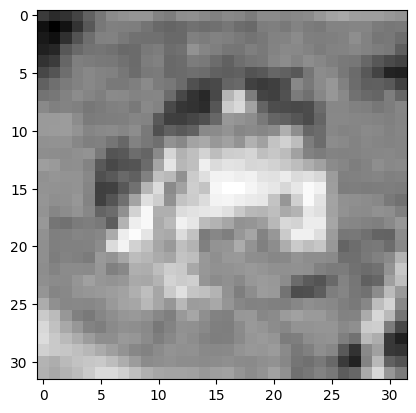

In [3]:
from matplotlib import pyplot as plt

print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

SGD를 위해 dataset을 여러 개의 batch로 나눈다.
여러 개의 batch로 나누면 데이터가 많아도 메모리가 부족하지 않게 gradient descent를 수행할 수 있다.
SGD는 랜덤으로 batch를 구성해야 잘 동작하기 때문에 trainloader에 shuffle=True로 설정한다.

In [4]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)


첫 번째 batch를 출력하면 다음과 같다.

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


dataloader에 대한 model의 정확도를 측정하는 코드를 추가한다.

In [6]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

모델을 학습하면서 저장한 정확도를 plot으로 출력하는 함수를 선언한다.

In [7]:
def plot_acc(train_accs, test_accs, label1, label2):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

### SGD vs Adam

LeakyReLU을 사용하는 3-layer MLP 모델을 구현한다. 

In [8]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    # 0~9까지 각 클래스에 대한 확률을 출력하기 위해 dimension을 10으로 설정
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(32 * 32 * 3, 1024)

gradient descent를 수행해줄 optimizer를 구현한다. SGD와 Adam을 사용한다.

In [9]:
from torch.optim import SGD, Adam

lr = 0.001
model = model.to('mps')

sgd_optimizer = SGD(model.parameters(), lr=lr)
adam_optimizer = Adam(model.parameters(), lr=lr)

model을 학습한다.
SGD의 성능을 측정하기 위해 배열에 정확도를 계산하여 저장한다.

In [10]:
criterion = nn.CrossEntropyLoss()
n_epochs = 50

sgd_train_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    sgd_optimizer.step()

    total_loss += loss.item()
  sgd_train_acc_list.append(accuracy(model, trainloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 451.14811754226685
Epoch   1 | Loss: 450.2908148765564
Epoch   2 | Loss: 449.40737414360046
Epoch   3 | Loss: 448.580792427063
Epoch   4 | Loss: 447.81026554107666
Epoch   5 | Loss: 447.094523191452
Epoch   6 | Loss: 446.37571120262146
Epoch   7 | Loss: 445.6939823627472
Epoch   8 | Loss: 445.0013282299042
Epoch   9 | Loss: 444.33336424827576
Epoch  10 | Loss: 443.64325737953186
Epoch  11 | Loss: 442.9713215827942
Epoch  12 | Loss: 442.25143694877625
Epoch  13 | Loss: 441.6075277328491
Epoch  14 | Loss: 440.8982253074646
Epoch  15 | Loss: 440.1737883090973
Epoch  16 | Loss: 439.5208411216736
Epoch  17 | Loss: 438.8014817237854
Epoch  18 | Loss: 438.03958916664124
Epoch  19 | Loss: 437.12902069091797
Epoch  20 | Loss: 435.9339315891266
Epoch  21 | Loss: 434.77215099334717
Epoch  22 | Loss: 433.6445851325989
Epoch  23 | Loss: 432.64183712005615
Epoch  24 | Loss: 431.5539724826813
Epoch  25 | Loss: 430.57140016555786
Epoch  26 | Loss: 429.5948443412781
Epoch  27 | Loss: 

Adam의 성능을 측정하기 위해 배열에 정확도를 계산하여 저장한다.

In [11]:
criterion = nn.CrossEntropyLoss()
n_epochs = 50

adam_train_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    adam_optimizer.step()

    total_loss += loss.item()
  adam_train_acc_list.append(accuracy(model, trainloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 417.2205333709717
Epoch   1 | Loss: 339.45481741428375
Epoch   2 | Loss: 315.916499376297
Epoch   3 | Loss: 303.04694414138794
Epoch   4 | Loss: 294.19255685806274
Epoch   5 | Loss: 285.8053011894226
Epoch   6 | Loss: 277.98451709747314
Epoch   7 | Loss: 272.54860043525696
Epoch   8 | Loss: 266.10283076763153
Epoch   9 | Loss: 262.9660634994507
Epoch  10 | Loss: 255.1988264322281
Epoch  11 | Loss: 250.97989916801453
Epoch  12 | Loss: 244.89740526676178
Epoch  13 | Loss: 242.4584882259369
Epoch  14 | Loss: 235.88721597194672
Epoch  15 | Loss: 230.71190464496613
Epoch  16 | Loss: 227.61740905046463
Epoch  17 | Loss: 222.10773718357086
Epoch  18 | Loss: 219.72411042451859
Epoch  19 | Loss: 211.50541299581528
Epoch  20 | Loss: 207.95748084783554
Epoch  21 | Loss: 204.83350104093552
Epoch  22 | Loss: 198.06421023607254
Epoch  23 | Loss: 195.60018038749695
Epoch  24 | Loss: 189.1362629532814
Epoch  25 | Loss: 186.03153896331787
Epoch  26 | Loss: 178.44265109300613
Epoch  27

SGD와 Adam의 성능을 비교한다.

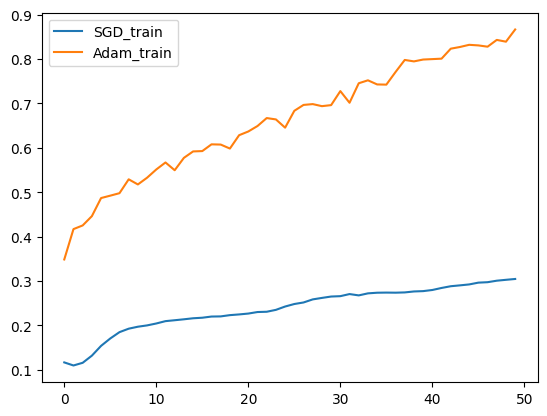

In [12]:
plot_acc(sgd_train_acc_list, adam_train_acc_list, 'SGD_train', 'Adam_train')

### LeakyReLU vs Sigmoid

LeakyReLU 모델을 구현한다.

In [13]:
from torch import nn


class ModelWithLeakyReLU(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    # 0~9까지 각 클래스에 대한 확률을 출력하기 위해 dimension을 10으로 설정
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model_with_leaky_relu = ModelWithLeakyReLU(32 * 32 * 3, 1024)

Sigmoid 모델을 구현한다.

In [14]:
from torch import nn

class ModelWithSigmoid(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    # 0~9까지 각 클래스에 대한 확률을 출력하기 위해 dimension을 10으로 설정
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model_with_sigmoid = ModelWithSigmoid(32 * 32 * 3, 1024)

gradient descent를 수행해줄 optimizer를 구현한다. Adam을 사용한다.

In [15]:
from torch.optim import SGD, Adam

lr = 0.001
model_with_leaky_relu = model_with_leaky_relu.to('mps')
model_with_sigmoid = model_with_sigmoid.to('mps')

leaky_relu_optimizer = Adam(model_with_leaky_relu.parameters(), lr=lr)
sigmoid_optimizer = Adam(model_with_sigmoid.parameters(), lr=lr)

LeakyReLU 모델을 학습한다.

In [16]:
criterion = nn.CrossEntropyLoss()
n_epochs = 50

leaky_relu_train_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model_with_leaky_relu.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model_with_leaky_relu(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    leaky_relu_optimizer.step()

    total_loss += loss.item()
  leaky_relu_train_acc_list.append(accuracy(model_with_leaky_relu, trainloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 435.56925988197327
Epoch   1 | Loss: 397.4174256324768
Epoch   2 | Loss: 376.05108201503754
Epoch   3 | Loss: 360.90127551555634
Epoch   4 | Loss: 347.4737013578415
Epoch   5 | Loss: 336.8340742588043
Epoch   6 | Loss: 326.94212090969086
Epoch   7 | Loss: 319.78423154354095
Epoch   8 | Loss: 312.13118278980255
Epoch   9 | Loss: 306.73069083690643
Epoch  10 | Loss: 301.8901790380478
Epoch  11 | Loss: 296.75432336330414
Epoch  12 | Loss: 292.92099726200104
Epoch  13 | Loss: 289.31909680366516
Epoch  14 | Loss: 283.9481246471405
Epoch  15 | Loss: 280.49676275253296
Epoch  16 | Loss: 278.6144822835922
Epoch  17 | Loss: 274.5078650712967
Epoch  18 | Loss: 272.3609768152237
Epoch  19 | Loss: 267.7644307613373
Epoch  20 | Loss: 266.5610874891281
Epoch  21 | Loss: 261.8840808868408
Epoch  22 | Loss: 259.0528715848923
Epoch  23 | Loss: 258.6658527851105
Epoch  24 | Loss: 253.56834471225739
Epoch  25 | Loss: 251.93239843845367
Epoch  26 | Loss: 249.58718633651733
Epoch  27 | Lo

Sigmoid 모델을 학습한다.
Sigmoid는 모든 입력값을 0과 1 사이로 압축한다.

In [17]:
criterion = nn.CrossEntropyLoss()
n_epochs = 50

sigmoid_train_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model_with_sigmoid.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model_with_sigmoid(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    sigmoid_optimizer.step()

    total_loss += loss.item()
  sigmoid_train_acc_list.append(accuracy(model_with_sigmoid, trainloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 412.2428605556488
Epoch   1 | Loss: 393.8173198699951
Epoch   2 | Loss: 388.17503476142883
Epoch   3 | Loss: 384.5638289451599
Epoch   4 | Loss: 381.5235834121704
Epoch   5 | Loss: 380.21916377544403
Epoch   6 | Loss: 377.9645162820816
Epoch   7 | Loss: 376.78321731090546
Epoch   8 | Loss: 375.1876890659332
Epoch   9 | Loss: 374.09304344654083
Epoch  10 | Loss: 372.2877186536789
Epoch  11 | Loss: 372.11402773857117
Epoch  12 | Loss: 370.47026097774506
Epoch  13 | Loss: 369.9496650695801
Epoch  14 | Loss: 368.6572630405426
Epoch  15 | Loss: 368.0707072019577
Epoch  16 | Loss: 367.0163869857788
Epoch  17 | Loss: 366.83253359794617
Epoch  18 | Loss: 365.4430387020111
Epoch  19 | Loss: 365.98288130760193
Epoch  20 | Loss: 364.9325774908066
Epoch  21 | Loss: 363.9646670818329
Epoch  22 | Loss: 364.5687977075577
Epoch  23 | Loss: 363.3548607826233
Epoch  24 | Loss: 362.536368727684
Epoch  25 | Loss: 361.1865131855011
Epoch  26 | Loss: 361.34870421886444
Epoch  27 | Loss: 36

LeakyReLU와 Sigmoid의 성능을 비교한다.

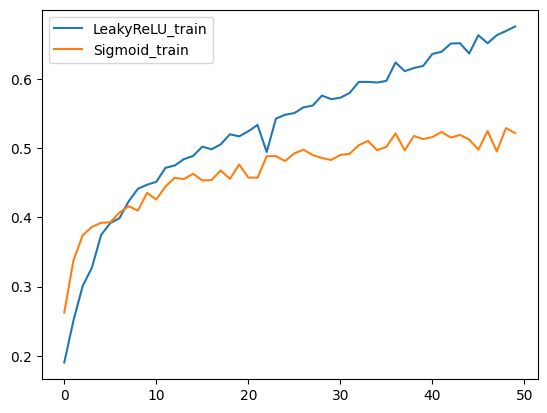

In [18]:
plot_acc(leaky_relu_train_acc_list, sigmoid_train_acc_list, 'LeakyReLU_train', 'Sigmoid_train')